# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Глушанина Мария Евгеньевна

**Дедлайн**: 13 октября 2023

In [ ]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

100%|██████████| 26421880/26421880 [00:02<00:00, 13181513.16it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207331.40it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3929201.84it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15152475.08it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [ ]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [ ]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [ ]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

        self.images = images
        self.labels = labels
        self.image_transform = image_transform
        self.label_transform = label_transform

    def __len__(self,):
        length = len(self.images)
        return length

    def __getitem__(self, idx):
        data_item = self.images[idx].reshape(28,28).astype(np.float32)
        label_item = int(self.labels[idx])

        if self.image_transform is not None:
            data_item = self.image_transform(data_item)
        if self.label_transform is not None:
            label_item = self.label_transform(label_item)

        return data_item, label_item


In [ ]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

In [ ]:
type(train_dataset[0][0][0][0])

numpy.float32

Визуализируйте случайные элементы набора данных.

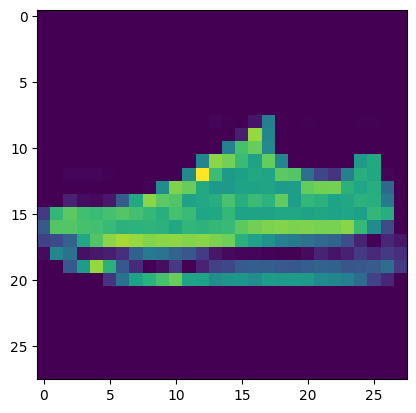

In [ ]:
import random

def plot_random_item(df):
    num = random.randint(0, df.__len__())
    plt.imshow(df.__getitem__(num)[0])


plot_random_item(train_dataset)

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [ ]:
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_tensor
from torch import from_numpy

class CustomToTensor(ToTensor):
    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float32)

In [ ]:
transform = CustomToTensor()
t_right = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=transform,
                            label_transform=None
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform,
                             label_transform=None
                             )

In [ ]:
print(f"The type of the data is {train_dataset[0][0][0][0].dtype}")

The type of the data is torch.float32


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [ ]:
def collate(batch):
    images, labels = zip(*batch)

    # Стекируем изображения и метки в соответствующие тензоры
    image_batch = torch.stack([img for img in images], dim=0)
    label_batch = torch.tensor(labels)

    return image_batch, label_batch

Убедитесть, что все работает корректно.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [ ]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [ ]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [ ]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = np.maximum(0, input)
        ctx.save_for_backward(input)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input<0] = 0

        return grad_input


In [ ]:
class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()

        return


    def forward(self, input):
        return ReLUFunction.apply(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [ ]:
x = torch.randn(5, requires_grad=True, dtype=torch.float64)
relu = ReLU()

assert gradcheck(relu, x)

In [ ]:
torch_relu = torch.nn.ReLU()
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearFunction(torch.autograd.Function):
    """
    Custom autograd function for a simple linear function: y = wx + b
    """
    @staticmethod
    def forward(ctx, x, w, b):
        ctx.save_for_backward(x, w, b)
        output = torch.mm(x, w.t()) + b
        return output

    @staticmethod
    def backward(ctx, grad_output):
        x, w, b = ctx.saved_tensors
        grad_input = torch.mm(grad_output, w)
        grad_weight = torch.mm(grad_output.t(), x)
        grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias


In [ ]:
class Linear(nn.Module):
    """
    Custom linear layer for a neural network: y = wx + b
    """
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        return LinearFunction.apply(x, self.weight, self.bias)


Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [ ]:
input_data = torch.randn(5, 3, requires_grad=True, dtype=torch.float64)
weight = torch.randn(4, 3, requires_grad=True, dtype=torch.float64)
bias = torch.randn(4, requires_grad=True, dtype=torch.float64)
assert gradcheck(LinearFunction.apply, (input_data, weight, bias), eps=1e-6, atol=1e-4)

Сравнение с `PyTorch`.

In [ ]:
import math

our_linear = Linear(3, 4)
torch_linear = nn.Linear(3, 4)

weight = torch.randn(4, 3)
bias = torch.randn(4)

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

input_data = torch.randn(5, 3)
output_our = our_linear(input_data)
output_torch = torch_linear(input_data)

if torch.allclose(output_our, output_torch):
    print("Outputs match between our linear and torch linear.")
else:
    print("Outputs do not match between our linear and torch linear.")

Outputs match between our linear and torch linear.


### 2.3 LogSoftmax (Log + Softmax)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Комментарий: разобраться `Log-Sum-Exp trick`

In [ ]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        max_val, _ = inp.max(dim=1, keepdim=True)
        log_softmax = inp - max_val - torch.log(torch.exp(inp - max_val).sum(dim=1, keepdim=True))

        ctx.save_for_backward(log_softmax)
        return log_softmax

    @staticmethod
    def backward(ctx, grad_output):
        log_softmax, = ctx.saved_tensors
        softmax = torch.exp(log_softmax)
        grad_input = grad_output - softmax * grad_output.sum(dim=1, keepdim=True)
        return grad_input

In [ ]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super(LogSoftmax, self).__init__()

    def forward(self, input):
        return LogSoftmaxFunction.apply(input)

Проверка градиентов.

In [ ]:
input_data = torch.randn(5, 3, requires_grad=True, dtype=torch.float64)
logsoftmax_layer = LogSoftmax()
assert gradcheck(logsoftmax_layer, (input_data,)), "Gradient check for LogSoftmax Module failed"

### 2.4 Dropout
Реализуйте слой Dropout.

In [ ]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):
        mask = torch.rand_like(inp) > p
        ctx.save_for_backward(mask)
        return inp * mask / (1-p)

    @staticmethod
    def backward(ctx, grad_output):
        mask, = ctx.saved_tensors
        return grad_output * mask, None, None

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, input):
        return DropoutFunction.apply(input, self.p)

### 2.5 CrossEntropy

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь кроссэнтропию. Реализуйте функцию потерь. В разделе 2.3 приведены полезные формулы.

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
from torch.autograd import gradcheck

class CrossEntropyLossFunction(Function):
    @staticmethod
    def forward(ctx, input, target):
        max_val, _ = input.max(dim=1, keepdim=True)
        input_shifted = input - max_val
        exp_input = input_shifted.exp()
        sum_exp = exp_input.sum(dim=1, keepdim=True)
        log_sum_exp = max_val + sum_exp.log()
        ctx.save_for_backward(input_shifted, sum_exp, target)
        loss = log_sum_exp - input_shifted.gather(1, target.view(-1, 1)).squeeze()
        return loss.mean()

    @staticmethod
    def backward(ctx, grad_output):
        input_shifted, sum_exp, target = ctx.saved_tensors
        softmax = input_shifted.exp() / sum_exp
        grad_input = softmax.clone()
        grad_input[range(target.size(0)), target] -= 1
        grad_input *= grad_output.view(-1, 1)
        grad_input /= target.size(0)
        return grad_input, None


In [ ]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, input, target):
        return CrossEntropyLossFunction.apply(input, target)

Проверка градиентов.

In [ ]:
#я максимально пыталась разобраться с jacobian mismatch но вышло пока только так
input = torch.randn(2, 3, requires_grad=True, dtype=torch.double)
target = torch.empty(2, dtype=torch.long).random_(3)

loss_fn = CrossEntropyLoss()
loss = loss_fn(input, target)

print("Loss:", loss.item())

# Run gradcheck to verify the gradients
gradcheck(loss_fn, (input, target), eps=1e-4, atol=1e-2)

Loss: 4.071556807966641


GradcheckError: ignored

## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10, activation_function=ReLU):
        super().__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_layers_size
        self.Flatten = nn.Flatten()

        self.layers = nn.ModuleList()
        self.layers.append(Linear(input_size, hidden_layers_size))
        self.layers.append(ReLU())
        self.layers.append(Dropout(p=0.2))

        for _ in range(num_layers - 1):
            self.layers.append(Linear(hidden_layers_size, hidden_layers_size))
            self.layers.append(activation_function())
            self.layers.append(Dropout(p=0.2))

        self.layers.append(Linear(hidden_layers_size, num_classes))
        self.layers.append(LogSoftmax())


    def forward(self, inp):
        inp = self.Flatten(inp)
        for layer in self.layers:
            inp = layer(inp)
        return inp



    def predict(self, inp):
        with torch.no_grad():
            output = self.forward(inp)
            _, predicted_class = output.max(dim=1)
        return predicted_class

Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать.

In [ ]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [ ]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

In [ ]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step()

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)

            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1
    return (total_loss / total_n, total_acc / total_n)

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [ ]:
model     = Network() #your network
optimizer = torch.optim.Adam(model.parameters()) #your optimizer
criterion = nn.CrossEntropyLoss() #использую свой лосс в доп.заданиях и сравню с этим

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 1.212225410990417, accuracy 0.5441964864730835
Current learning rate: 0.001
Epoch - 1 : loss 1.0489435324370862, accuracy 0.6134357452392578
Current learning rate: 0.001
Epoch - 2 : loss 0.9975426961928606, accuracy 0.6401225328445435
Current learning rate: 0.001
Epoch - 3 : loss 0.9720682567730546, accuracy 0.6540231704711914
Current learning rate: 0.001
Epoch - 4 : loss 0.9564733352456242, accuracy 0.65533846616745
Current learning rate: 0.001
Epoch - 5 : loss 0.9322065105102957, accuracy 0.666975736618042
Current learning rate: 0.001
Epoch - 6 : loss 0.9071236151009798, accuracy 0.6757755875587463
Current learning rate: 0.001
Epoch - 7 : loss 0.8976876159906387, accuracy 0.6810258030891418
Current learning rate: 0.001
Epoch - 8 : loss 0.8847544702775776, accuracy 0.6865255832672119
Current learning rate: 0.001
Epoch - 9 : loss 0.9008588659930974, accuracy 0.6736418008804321
Current learning rate: 0.001


In [ ]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 0.9008588659930974, accuracy 0.6736418008804321
Current learning rate: 0.001


Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

Epoch - 0 : loss 38.51566456747055, accuracy 0.07468342781066895
Epoch - 1 : loss 38.60792798757553, accuracy 0.07451681792736053
Epoch - 2 : loss 38.57331149220467, accuracy 0.07556688040494919
Epoch - 3 : loss 38.70168957233429, accuracy 0.07456681877374649
Epoch - 4 : loss 38.61690561246872, accuracy 0.07441685348749161
Epoch - 5 : loss 38.501495959758756, accuracy 0.07558360695838928
Epoch - 6 : loss 38.56737844133377, accuracy 0.07615035772323608
Epoch - 7 : loss 38.582391882658, accuracy 0.07426676899194717
Epoch - 8 : loss 38.42768461155892, accuracy 0.074300117790699
Epoch - 9 : loss 38.54865217852593, accuracy 0.07603352516889572
Epoch - 0 : loss 2.996047414600849, accuracy 0.10576838254928589
Epoch - 1 : loss 3.0071584304571153, accuracy 0.10610164701938629
Epoch - 2 : loss 2.9960055177807807, accuracy 0.10553495585918427
Epoch - 3 : loss 3.0061565734744073, accuracy 0.10523491352796555
Epoch - 4 : loss 3.0046622497439386, accuracy 0.10716841369867325
Epoch - 5 : loss 2.99745

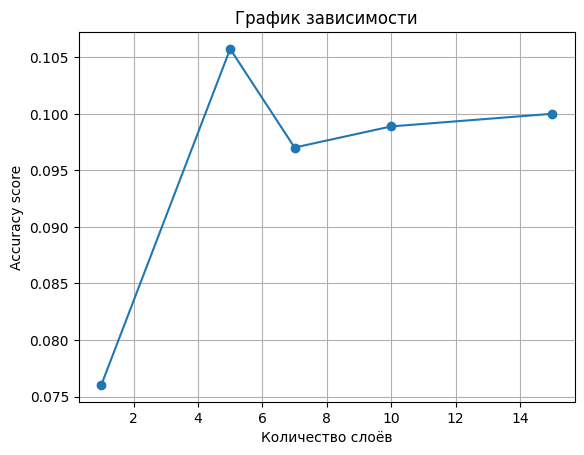

In [ ]:
#эксперименты с числом слоёв

num_layers = [1, 5, 7, 10, 15]
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
fin_score = []

for num in num_layers:
    model= Network(num_layers=num)
    model.to(device)

    for epoch in range(10):
        loss, acc = perform_epoch(model, train_dataloader, criterion,
                                    optimizer=optimizer, device=device)
        print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    fin_score.append(acc)


plt.plot(num_layers, fin_score, marker='o', linestyle='-')
plt.xlabel('Количество слоёв')
plt.ylabel('Accuracy score')
plt.title('График зависимости')
plt.grid(True)
plt.show()



Выводы: приращение слоёв помогает, но имеет нелинейную зависимость

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [ ]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

In [ ]:
class FTRLFunction(Function):
    @staticmethod
    def forward(ctx, weights, z, n, alpha, beta, l1, l2, grad):
        ctx.save_for_backward(weights, z, n, alpha, beta, l1, l2, grad)

        sigma = (torch.sqrt(n + z * z) - torch.sqrt(n)) / alpha
        weights = weights - (1.0 / beta) * (torch.sign(weights) * l1 - z / sigma + grad) * (1.0 / (l2 + (beta + sigma) * (beta + sigma)))

        return weights

    @staticmethod
    def backward(ctx, grad_output):
        weights, z, n, alpha, beta, l1, l2, grad = ctx.saved_tensors

        grad_weights = grad_output
        grad_z = grad_output * (1.0 / alpha + beta * 2.0 * weights) * (1.0 / (1.0 + weights * weights))
        grad_n = grad_z * grad_z

        grad_alpha = (grad_output * (z / (alpha * alpha)) - grad_z * z / (alpha * alpha) - grad_n * 0.5) * (torch.sign(alpha) + 1.0)
        grad_beta = grad_output * (-torch.log(1.0 + z * z) + torch.log(1.0 + grad_n) + 0.5 * torch.log(1.0 + weights * weights)) * (torch.sign(beta) + 1.0)
        grad_l1 = grad_output * torch.sign(weights)
        grad_l2 = grad_output * 2.0 * weights
        grad_grad = grad_output

        return grad_weights, grad_z, grad_n, grad_alpha, grad_beta, grad_l1, grad_l2, grad_grad

class FTRL(Optimizer):
    def __init__(self, params, lr=0.01, alpha=1.0, beta=1.0, l1=0.0, l2=0.0):
        defaults = dict(lr=lr, alpha=alpha, beta=beta, l1=l1, l2=l2)
        super(FTRL, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            alpha = group['alpha']
            beta = group['beta']
            l1 = group['l1']
            l2 = group['l2']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if 'z' not in state:
                    state['z'] = torch.zeros_like(p.data)
                if 'n' not in state:
                    state['n'] = torch.zeros_like(p.data)

                z = state['z']
                n = state['n']

                updated_weights = FTRLFunction.apply(p.data, z, n, alpha, beta, l1, l2, grad)
                z.add_(grad - (updated_weights - p.data) * lr)
                n.add_(grad * grad)

                p.data = updated_weights

        return loss

In [ ]:
optimizer1 = torch.optim.Adam(model.parameters())
optimizer2 = FTRL(model.parameters(), lr=0.1, alpha=1.0, beta=1.0, l1=0.0, l2=0.0)
opts = [optimizer1, optimizer2]
opts_name = ['Adam', 'FTRL']
criterion = CrossEntropyLoss()
fin_score = []

for opt in range(len(opts)):
    model= Network()
    model.to(device)
    opt_name = opts_name[opt]

    for epoch in range(5):
        loss, acc = perform_epoch(model, train_dataloader, criterion,
                                    optimizer=opts[opt], device=device)
        print(f"Optimizer - {opt_name}, Epoch - {epoch} : loss {loss}, accuracy {acc}")
    fin_score.append(acc)

Optimizer - Adam, Epoch - 0 : loss 1.2500524741783738, accuracy 0.10548502206802368
Optimizer - Adam, Epoch - 1 : loss 1.2544473147168755, accuracy 0.1049017608165741
Optimizer - Adam, Epoch - 2 : loss 1.2509619384482502, accuracy 0.1054016500711441
Optimizer - Adam, Epoch - 3 : loss 1.2476943512111902, accuracy 0.1057015061378479
Optimizer - Adam, Epoch - 4 : loss 1.2534376269057392, accuracy 0.10618490725755692
Optimizer - FTRL, Epoch - 0 : loss 2.2726023986637593, accuracy 0.1026182696223259
Optimizer - FTRL, Epoch - 1 : loss 2.2706765853762625, accuracy 0.1027349904179573
Optimizer - FTRL, Epoch - 2 : loss 2.2610332568734886, accuracy 0.10431811958551407
Optimizer - FTRL, Epoch - 3 : loss 2.2710889247506856, accuracy 0.10358494520187378
Optimizer - FTRL, Epoch - 4 : loss 2.2710255908966066, accuracy 0.10216826945543289


In [ ]:
fin_score

[tensor(0.1062), tensor(0.1022)]

In [ ]:
#адам чуть получше справился

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.

In [ ]:
class HardSwishFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input * torch.clamp(input + 3, 0, 6) / 6

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < -3] = 0
        grad_input[input > 3] = grad_input[input > 3] * (input[input > 3] / 3)
        return grad_input

class HardSwish(nn.Module):
    def forward(self, input):
        return HardSwishFunction.apply(input)

In [ ]:
import torch
import torch.nn as nn

# SoftClipping Activation Function as a standalone function
class SoftClippingActivationFunction:
    def __init__(self, alpha=1.0, beta=2.0):
        self.alpha = alpha
        self.beta = beta

    def __call__(self, x):
        return self.alpha * torch.log(1 + torch.exp(self.beta * x)) / self.beta

# SoftClipping Activation Module as a PyTorch nn.Module
class SoftClippingActivation(nn.Module):
    def __init__(self, alpha=1.0, beta=2.0):
        super(SoftClippingActivation, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, x):
        return self.alpha * torch.log(1 + torch.exp(self.beta * x)) / self.beta


In [ ]:
optimizer = torch.optim.Adam(model.parameters()) #your optimizer
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activations = [ReLU, HardSwish, SoftClippingActivation]
act_names = ['ReLU', 'HardSwish', 'SoftClippingActivation']
fin_scores = []

for activation in range(len(activations)):
    model = Network(activation_function=activations[activation]) #your network
    model.to(device)
    act_name = act_names[activation]
    for epoch in range(5):
        loss, acc = perform_epoch(model, train_dataloader, criterion,
                                    optimizer=optimizer, device=device)
        print(f"Activation - {act_name}, Epoch - {epoch} : loss {loss}, accuracy {acc}")
    fin_scores.append(acc)

Activation - ReLU, Epoch - 0 : loss 3.0257985436320305, accuracy 0.09540141373872757
Activation - ReLU, Epoch - 1 : loss 3.0259811367988587, accuracy 0.09571784734725952
Activation - ReLU, Epoch - 2 : loss 3.0252048024237155, accuracy 0.09640134871006012
Activation - ReLU, Epoch - 3 : loss 3.02885252019763, accuracy 0.09663474559783936
Activation - ReLU, Epoch - 4 : loss 3.014399968445301, accuracy 0.09545118361711502
Activation - HardSwish, Epoch - 0 : loss 3.0299205566346648, accuracy 0.09155112504959106
Activation - HardSwish, Epoch - 1 : loss 3.03397320908308, accuracy 0.08940105140209198
Activation - HardSwish, Epoch - 2 : loss 3.032230100363493, accuracy 0.0919511616230011
Activation - HardSwish, Epoch - 3 : loss 3.038664170861244, accuracy 0.08981779962778091
Activation - HardSwish, Epoch - 4 : loss 3.0310003487467765, accuracy 0.090817891061306
Activation - SoftClippingActivation, Epoch - 0 : loss nan, accuracy 0.1061517745256424
Activation - SoftClippingActivation, Epoch - 1 :

In [ ]:
fin_scores

[tensor(0.0955), tensor(0.0908), tensor(0.1068)]

In [ ]:
#справился лучше всех SoftClipping